# Back Propagation

Here is an implementation of the basic back propagation algorithm. This is meant for educational purposes and should not be used in any production environment.

In this notebook, we will implement our back propagation algorithm using gradient descent and Relu non-linearities through a small network. We will also test our back propagation implementation against a simple problem of approximating mathematical functions.

I will not explain in detail the mathematics and reasoning of the implementation, but will link to external sources that do a sufficient job at doing so. [Here](http://neuralnetworksanddeeplearning.com/chap2.html) is a good place to start for getting a foundation of back propagation.

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

All the models to learn in this network will take 2 inputs and give 1 output. The output is a classification variable that can take on a value between 0 and 1. Values closer to 0 indicate preference for class 0 while values for class 1 prefer class 1.

We will define 3 functions that our neural networks should learn after training:

## Model 1: Inside of Ellipsis

In [133]:
num_points = 10000

In [134]:
def create_ellipse_func(a, b):
    def ellipse_func(x, y):
        return 1 if ((x*x) / (a*a) + (y*y) / (b*b)) <= 1 else 0

    return ellipse_func


In [135]:
model1_func = create_ellipse_func(2.0, 4.0)
model1_points = 8 * np.random.rand(2, num_points) - 4
model1_categories = np.apply_along_axis(lambda x: model1_func(x[0], x[1]), axis=0, arr=model1_points)

split_mask = np.random.rand(num_points) <= 0.6

model1_training = model1_points[:, split_mask]
model1_training_categories = model1_categories[split_mask]

model1_test = model1_points[:, ~split_mask]
model1_test_categories = model1_categories[~split_mask]

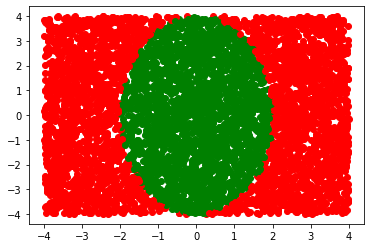

In [136]:
# Let's make a plot to see where the ellipse is being drawn.

for i in range(len(model1_training_categories)):
    point = model1_training[:, i]
    category = model1_training_categories[i]
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

## Model 2: Guassian

In [137]:
def create_gaussian_curve(mean, variance, delta=0.2):
    std = math.sqrt(variance)
    normalize = 1 / (std * math.sqrt(2 * 3.14159))

    def gaussian_curve(x, y):
        term = (x - mean) / std
        expected = normalize * np.exp(-1/2 * term * term)
        return 1 if abs(expected - y) <= delta else 0
    
    return gaussian_curve


In [138]:
model2_func = create_gaussian_curve(0.0, 0.05)
model2_points = np.random.rand(2, num_points) * 4 - 2
model2_categories = np.apply_along_axis(lambda x: model2_func(x[0], x[1]), axis=0, arr=model2_points)

split_mask = np.random.rand(num_points) <= 0.6

model2_training = model2_points[:, split_mask]
model2_training_categories = model2_categories[split_mask]

model2_test = model2_points[:, ~split_mask]
model2_test_categories = model2_categories[~split_mask]

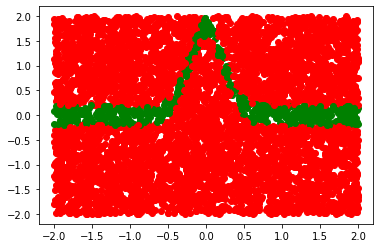

In [139]:
# Let's make a plot to see where the gaussian curve is being drawn.

for i in range(len(model2_training_categories)):
    point = model2_training[:, i]
    category = model2_training_categories[i]
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

## Feed Forward Network

We will design a simple feed-forward network with relu activation.

### Activation Functions

In [140]:
def relu(X):
    mask = X >= 0
    return X * mask
    

In [141]:
def relu_deriv(X):
    return (X >= 0).astype(float)


In [142]:
def sigmoid(X):
    return 1. / (1 + np.exp(-X))


In [143]:
def sigmoid_deriv(X):
    sig = sigmoid(X)
    return sig * (1 - sig)


### Loss Functions

In [144]:
def binary_cross_entropy_loss(output, expected):
    # Offset the output if there are any values exactly equal to
    # zero or one to avoid log(0).
    zero_correct = (output == 0).astype(float) * 1e-10 
    one_correct = (output == 1).astype(float) * (-1e-10)
    output = output + zero_correct + one_correct

    return np.sum((expected * -np.log(output)) + (1 - expected) * -np.log(1 - output))


In [145]:
def binary_cross_entropy_loss_grad(output, expected):
    # Want to avoid divide by 0.
    epsilon = 1e-10
    zero_correct = (output == 0.0).astype(float) * epsilon
    one_correct = (output == 1.0).astype(float) * -epsilon
    output = output + zero_correct + one_correct
    
    return ((expected / output) - (1 - expected) / (1 - output))


### Defining the Model

In [146]:
# Note: When initializing the layers, we will assume that the output
# layer is always a single output through a sigmoid activation.
def xavier_initialization(input_size, layer_sizes):
    layers = []
    
    prev_layer_size = input_size

    for size in layer_sizes:
        normalize = 1. / math.sqrt(prev_layer_size)
        weights = np.random.randn(size, prev_layer_size) * normalize
        biases = np.random.randn(size, 1) * normalize
        layers.append((weights, biases))

        prev_layer_size = size
        
    # Add a final output layer for sigmoid activation.
    weights = np.random.randn(1, prev_layer_size)
    biases = np.random.randn(1, 1)
    layers.append((weights, biases))
    
    return layers
    

In [147]:
def forward(model, X):
    Y = X

    linear_outputs = []
    outputs = []

    for (i, (weights, biases)) in enumerate(model['layers'][0:-1]):
        Y = np.dot(weights, Y) + biases
        linear_outputs.append(Y)

        Y = relu(Y)
        outputs.append(Y)
        

    # Note: Last layer is processed by sigmoid activation.
    weights, biases = model['layers'][-1]

    Y = np.dot(weights, Y) + biases
    linear_outputs.append(Y)

    Y = sigmoid(Y)
    outputs.append(Y)

    # Save the results of the forward pass so we can do a backward
    # pass on them later.
    if 'no_grad' not in model or not model['no_grad']:
        model['linear_outputs'] = linear_outputs
        model['input'] = X
        model['outputs'] = outputs
        model['result'] = Y

    return Y
 

In [148]:
def backward(model, expected):
    # Note: We are assuming the model has already gone through a
    # forward pass.

    layers = model['layers']
    linear_outputs = model['linear_outputs']
    outputs = model['outputs']
    X = model['input']
    result = model['result']

    L = len(layers)
    m = result.shape[1] # Number of samples.

    # Keep track of error derivatives and gradients. These lists represent
    # the errors and gradients in reverse order with respect to the layers
    # in the network. The order is reversed after all the computations have
    # been completed.
    errors = []
    grads = []

    # Note: We can have multiple samples in the outputs, so we
    # will end up with a gradient per sample.
    loss_grad = binary_cross_entropy_loss_grad(result, expected)

    linear_output = linear_outputs[-1]
    output_prev_layer = X if len(outputs) <= 1 else outputs[-2]
    error_last_layer = loss_grad * sigmoid_deriv(linear_output)

    bias_grad = np.sum(error_last_layer, axis=1).reshape(-1, 1)
    weights_grad = np.dot(error_last_layer, output_prev_layer.T) # outer product
    grad_last_layer = (weights_grad, bias_grad)

    errors.append(error_last_layer)
    grads.append((weights_grad, bias_grad))

    # Enumerate layers in reverse order to compute errors
    # and gradients.
    for i in range(L - 2, -1, -1):
        linear_output = linear_outputs[i]
        output_prev_layer = X if i == 0 else outputs[i-1]
        error_next_layer = errors[-1]
        weights_next_layer, bias_next_layer = layers[i+1]

        error = np.dot(weights_next_layer.T, error_next_layer) * relu_deriv(linear_output)
        bias_grad = np.sum(error, axis=1).reshape(-1, 1) / m
        weights_grad = np.dot(error, output_prev_layer.T) / m
        
        errors.append(error)
        grads.append((weights_grad, bias_grad))
        
    # Reverse the order of errors and gradients so they go from
    # first layer to last.
    errors.reverse()
    grads.reverse()
    
    if 'no_grad_check' not in model or not model['no_grad_check']:
        model['errors'] = errors
        model['grads'] = grads
    
    return grads, errors


In [149]:
def step_SGD(model, lr, batch_size):
    # Note: We are assuming the model has already gone
    # through back propagation and all the gradients have
    # been calculated.
    
    new_layers = []

    for (i, layer) in enumerate(model['layers']):
        weight, bias = layer
        grad_weight, grad_bias = model['grads'][i]
        
        weight = weight + (lr / batch_size * grad_weight)
        bias = bias + (lr / batch_size * grad_bias)

        model['layers'][i] = (weight, bias)


In [150]:
def grad_on(model):
    if 'no_grad' in model:
        del model['no_grad']

In [151]:
def grad_off(model):
    model['no_grad'] = True


In [152]:
def clear(model):
    """
    Clear any state that has been saved to the model
    during training.
    """
    keys = ['errors', 'grads', 'input', 'linear_outputs', 'loss', 'loss_grads', 'outputs', 'result']
    
    for key in keys:
        if key in model:
            del model[key]
    

In [153]:
def predict(model, X, threshold=0.5):
    should_toggle_no_grad = 'no_grad' in model and model['no_grad']
    
    if should_toggle_no_grad:
        grad_off(model)

    Y = forward(model, X)
    
    if should_toggle_no_grad:
        grad_on(model)

    return (Y >= threshold).astype(float)


## Gradient Checking

In [154]:
def copy(model):
    model = { 'layers': model['layers'] }
    return model
    

In [155]:
def grad_check(model, X, Y, epsilon=1e-5):
    model = copy(model)
    grad_off(model)
    
    # STEP 1: Generate estimates for back propagation
    # using multiple passes of forward propagation.

    grad_estimates = []

    for (l, layer) in enumerate(model['layers']):
        weight, bias = layer
        grad_weight = np.zeros_like(weight)
        for i in range(weight.shape[0]):
            for j in range(weight.shape[1]):
                weight_orig = weight[i, j]

                # Calculate loss with up weight.
                weight_up = weight[i, j] + epsilon
                model['layers'][l][0][i, j] = weight_up
                Y_hat_up = forward(model, X)
                loss_up = binary_cross_entropy_loss(Y_hat_up, Y)
                
                # Calculate loss with down weight.
                weight_down = weight[i, j] - epsilon
                model['layers'][l][0][i, j] = weight_down
                Y_hat_down = forward(model, X)
                loss_down = binary_cross_entropy_loss(Y_hat_down, Y)
                
                # Record estimated gradient.
                grad_weight[i, j] = (loss_up - loss_down) / (2 * epsilon)
                
                # Reset original weight.
                model['layers'][l][0][i, j] = weight_orig
                


        grad_bias = np.zeros_like(bias)
        for i in range(bias.shape[0]):
            bias_orig = bias[i, 0]

            # Calculate loss with up bias.
            bias_up = bias[i, 0] + epsilon
            model['layers'][l][1][i, 0] = bias_up
            Y_hat_up = forward(model, X)
            loss_up = binary_cross_entropy_loss(Y_hat_up, Y)
                
            # Calculate loss with down bias.
            bias_down = bias[i, 0] - epsilon
            model['layers'][l][1][i, 0] = bias_down
            Y_hat_down = forward(model, X)
            loss_down = binary_cross_entropy_loss(Y_hat_down, Y)
                
            # Record estimated gradient.
            grad_bias[i, 0] = (loss_up - loss_down) / (2 * epsilon)
            
            # Reset original bias.
            model['layers'][l][1][i, 0] = bias_orig
        
        grad_estimates.append((grad_weight, grad_bias))

    grad_on(model)
    
    # STEP 2: Generate the actual gradients using back propagation.
    forward(model, X)
    backward(model, Y)
    
    # STEP 3: Figure out the difference between the estimates and
    # actual gradients.
    error = 0
    num_params = 0

    for (i, grad) in enumerate(model['grads']):
        grad_weight, grad_bias = grad
        grad_weight_hat, grad_bias_hat = grad_estimates[i]
        
        weight_errors_sqrt = grad_weight - grad_weight_hat
        bias_errors_sqrt = grad_bias - grad_bias_hat
        
        weight_errors = weight_errors_sqrt * weight_errors_sqrt
        bias_errors = bias_errors_sqrt * bias_errors_sqrt

        error += np.sum(weight_errors)
        error += np.sum(bias_errors)
        
        num_params += np.prod(grad_weight.shape)
        num_params += np.prod(grad_bias.shape)

    return error / num_params


## Creating and Training the Model

### Model 1

In [156]:
model1 = { 'layers': xavier_initialization(input_size=2, layer_sizes=[10, 4]) }


In [157]:
X = model1_training
Y = model1_training_categories

grad_check_errors = []

epochs = 1000
batch_size = 100
n = X.shape[1]

model1_train_errors = []
model1_test_errors = []

for i in range(epochs):
    for (batch_i, batch_start) in enumerate(range(0, n, batch_size)):
        batch_X = X[:, batch_i:min(n, batch_start+batch_size)]
        batch_Y = Y[batch_i:min(n, batch_start+batch_size)]

        forward(model1, batch_X)
        backward(model1, batch_Y)
        step_SGD(model1, lr=0.1, batch_size=batch_size)

    # Turn off gradient checking while we calculate training
    # and test loss.
    grad_off(model1)

    if i % 10 == 0:
        train_output = forward(model1, X)
        train_error = binary_cross_entropy_loss(train_output, Y) / len(Y)

        test_output = forward(model1, model1_test)
        test_error = binary_cross_entropy_loss(test_output, model1_test_categories) / len(model1_test_categories)
        
        model1_train_errors.append(train_error)
        model1_test_errors.append(test_error)

        if i % 100 == 0:
            print(f'Epoch {i + 1}')
            print(f'Train Error {train_error}')
            print('')
    
    # Turn gradient checking back on before we start a new epoch.
    grad_on(model1)


Epoch 1
Train Error 0.5701158641242693

Epoch 101
Train Error 0.037671830833337486

Epoch 201
Train Error 0.027105610094214503

Epoch 301
Train Error 0.022916734554744814

Epoch 401
Train Error 0.020559705890352026

Epoch 501
Train Error 0.019038068734003686

Epoch 601
Train Error 0.01798199581901486

Epoch 701
Train Error 0.01713145440564209

Epoch 801
Train Error 0.01644249389967557

Epoch 901
Train Error 0.01592105964117574



### Model 2

In [161]:
model2 = { 'layers': xavier_initialization(input_size=2, layer_sizes=[20, 10, 4]) }


In [162]:
X = model2_training
Y = model2_training_categories

epochs = 1000
batch_size = 100
n = X.shape[1]

model2_train_errors = []
model2_test_errors = []

for i in range(epochs):
    for (batch_i, batch_start) in enumerate(range(0, n, batch_size)):
        batch_X = X[:, batch_start:min(n, batch_start+batch_size)]
        batch_Y = Y[batch_start:min(n, batch_start+batch_size)]

        forward(model2, batch_X)
        backward(model2, batch_Y)
        step_SGD(model2, lr=0.1, batch_size=batch_size)

    
    # Turn off gradient checking while we calculate training
    # and test loss.
    grad_off(model2)

    if i % 10 == 0:
        train_output = forward(model2, X)
        train_error = binary_cross_entropy_loss(train_output, Y) / len(Y)

        test_output = forward(model2, model2_test)
        test_error = binary_cross_entropy_loss(test_output, model2_test_categories) / len(model2_test_categories)
        
        model2_train_errors.append(train_error)
        model2_test_errors.append(test_error)

        if i % 100 == 0:
            print(f'Epoch {i + 1}')
            print(f'Train Error {train_error}')
            print('')
    
    # Turn gradient checking back on before we start a new epoch.
    grad_on(model2)


Epoch 1
Train Error 0.364398770397989

Epoch 101
Train Error 0.22271896198528318

Epoch 201
Train Error 0.14179922850745041

Epoch 301
Train Error 0.10158505662073922

Epoch 401
Train Error 0.08425408428452015

Epoch 501
Train Error 0.0735184909677964

Epoch 601
Train Error 0.06546365448508837

Epoch 701
Train Error 0.058694232961426694

Epoch 801
Train Error 0.05354174431196124

Epoch 901
Train Error 0.048622690315750006



## Viewing the Results

### Model 1

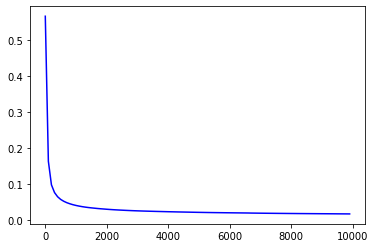

In [163]:
x = [i*100 for i in range(len(model1_test_errors))]

# plt.plot(x, model1_train_errors, 'green')
plt.plot(x, model1_test_errors, 'blue')
plt.show()

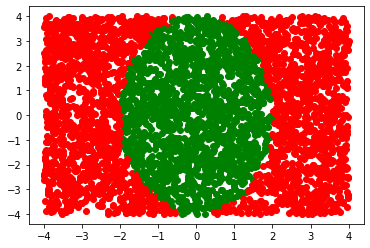

In [164]:
n = model1_test.shape[1]

for i in range(n):
    point = model1_test[:, i].reshape(-1, 1)
    category = predict(model1, point)
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

**NOTE: Notice the sharp edges that define our model for the ellipse. This is likely caused by the fact that we are using a very small neural network to train this model. Since the relu activation function is nearly linear and there are very few layers, the linearities in the learned model are very apparent.**

### Model 2

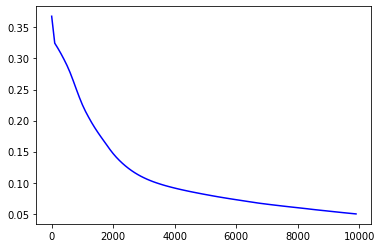

In [165]:
x = [i*100 for i in range(len(model2_test_errors))]

# plt.plot(x, model2_train_errors, 'green')
plt.plot(x, model2_test_errors, 'blue')
plt.show()

In [ ]:
n = model2_test.shape[1]

for i in range(n):
    point = model2_test[:, i].reshape(-1, 1)
    category = predict(model2, point)
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

**NOTE: While our second model did show improvement, it failed to learn the curve of the guassian function. I will continue to explore this more in a separate notebook.**